In [1]:
import os

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import tqdm

In [3]:
from utils import nethook
from utils.runningstats import RunningCovariance
from utils.seqstylegan2 import SeqStyleGAN2

In [4]:
device = torch.device('cuda')
IMG_SIZE = 256
LATENT_DIM = 512

In [5]:
# Load sequential stylegan2
stylegan = SeqStyleGAN2(
    size=IMG_SIZE, style_dim=LATENT_DIM, n_mlp=8, truncation=1, mconv='seq')
stylegan.to(device)
_ = stylegan.requires_grad_(False)

In [6]:
# Load checkpoint
ckpt = torch.load('./release/stylegan2-church-config-f.pt')
stylegan.load_state_dict(ckpt['g_ema'], latent_avg=ckpt['latent_avg'])

In [7]:
# target feature map
target_layer = 8

# layer name
target_first = 'layer{}.sconv.mconv.dconv'.format(target_layer)
target_last = 'layer{}.sconv.activate'.format(target_layer)

# split
context_model = nethook.subsequence(
    stylegan,
    upto_layer=target_first,
    share_weights=True)
target_model = nethook.subsequence(
    stylegan,
    first_layer=target_first,
    last_layer=target_last,
    share_weights=True)
render_model = nethook.subsequence(
    stylegan,
    after_layer=target_last,
    share_weights=True)

In [8]:
def postproc(sample):
    """Postprocessor, min-max normalization, BHWC permutation.
    Args:
        sample: torch.Tensor, [B, C, H, W], generated image.
    Returns:
        np.ndarray, [B, H, W, C], normalized image in range [0, 1].
    """
    sample = sample.permute(0, 2, 3, 1).cpu().detach().numpy()
    min_ = sample.min(axis=(1, 2, 3), keepdims=True)
    max_ = sample.max(axis=(1, 2, 3), keepdims=True)
    sample = (sample - min_) / (max_ - min_)
    return sample

In [9]:
def show(sample, row=2, size=5):
    bsize = len(sample)
    plt.figure(figsize=(bsize // row * size, row * size))
    for i in range(bsize):
        plt.subplot(row, bsize // row, i + 1)
        plt.imshow(sample[i])

In [10]:
zdump = np.load('./dataset/zdump.npy', allow_pickle=True).item()
z = torch.tensor(zdump['z'], device=device)
z.shape

torch.Size([8, 512])

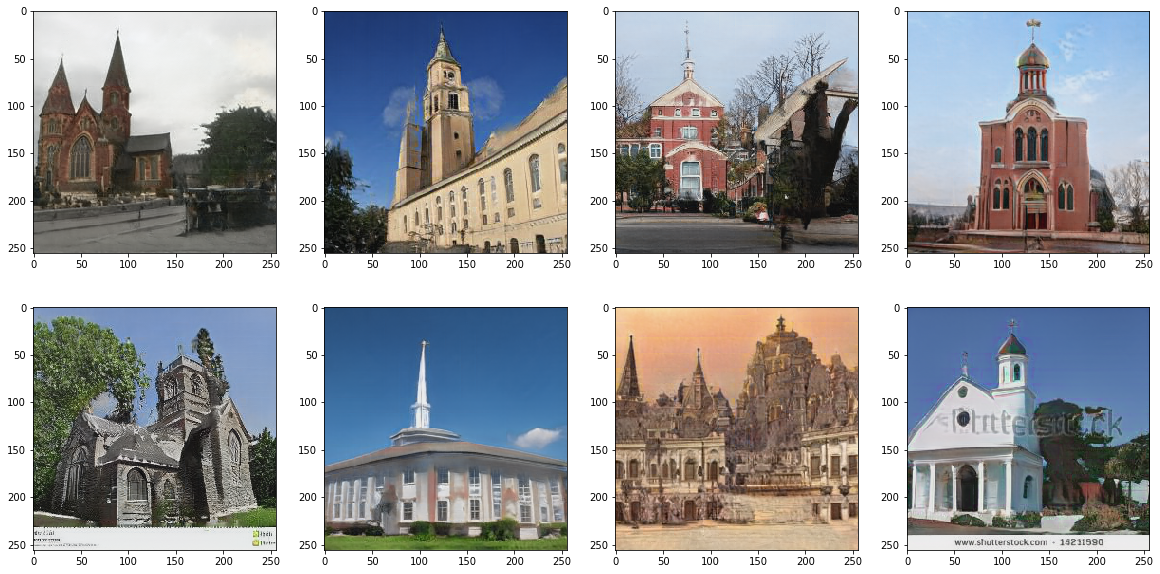

In [11]:
context = context_model(z)
sample = postproc(render_model(target_model(context)))
show(sample)

In [12]:
subbatch = 32
num_sample = 1000

zs = torch.randn(num_sample, LATENT_DIM, device=device)
stats = RunningCovariance()

for i in range(num_sample // subbatch):
    keys = context_model(zs[i * subbatch:(i + 1) * subbatch]).fmap
    keys = keys.permute(0, 2, 3, 1).reshape(-1, LATENT_DIM)
    stats.add(keys)

mean, cov = stats.mean(), stats.covariance()

In [13]:
maskdir = './dataset/masks_proc'
masks = np.stack([plt.imread(os.path.join(maskdir, fname)) for fname in os.listdir(maskdir) if 'value' not in fname])
masks = torch.tensor(masks, dtype=torch.float, device=device) / 255.
masks.shape

torch.Size([8, 256, 256])

In [14]:
context_masks = F.interpolate(masks[:, None], context.fmap.shape[2:], mode='bilinear')
context_masks.shape

torch.Size([8, 1, 32, 32])

In [15]:
channels = context.fmap.shape[1]
masked_keys = context.fmap * context_masks
masked_keys = masked_keys.permute(0, 2, 3, 1).reshape(-1, channels)
masked_keys = masked_keys[masked_keys.norm(2, dim=1) > 0, :]
masked_keys.shape

torch.Size([192, 512])

In [16]:
def cov_inv_keys(cov, keys):
    """
    Args:
        cov: torch.Tensor, [C, C], covariance.
        keys: torch.Tensor, [B, C], keys.
    Returns:
        torch.Tensor, [B, C], C^{-1}k.
    """
    return torch.lstsq(keys.T, cov).solution.T

d = cov_inv_keys(cov, masked_keys)
d.shape

torch.Size([192, 512])

In [17]:
avg = masked_keys.mean(0)
u, s, v = torch.svd(d.T, some=False)
if (avg * u[:, 0]).sum() < 0:
    u[:, 0] = -u[:, 0]

rank = 16
basis = u.T[:rank]
basis.shape

torch.Size([16, 512])

In [18]:
input_key = context_model(z[0:1])
input_value = target_model(input_key)
input_key.fmap.shape, input_value.fmap.shape

(torch.Size([1, 512, 32, 32]), torch.Size([1, 512, 32, 32]))

In [19]:
value_mask = plt.imread('./dataset/masks_proc/mask_value_resized.jpg').astype(np.float32) / 255.
value_mask = torch.tensor(value_mask, device=device)
value_mask = F.interpolate(value_mask[None, None], input_value.fmap.shape[2:], mode='bilinear')
value_mask.shape

torch.Size([1, 1, 32, 32])

In [20]:
def bbox_from_mask(mask):
    coords = (mask > 0).nonzero()
    top, bottom = coords[:, 2].min(), coords[:, 2].max()
    left, right = coords[:, 3].min(), coords[:, 3].max()
    return top, bottom, left, right

In [21]:
def matching_center(vbox, kbox):
    tv, bv, lv, rv = vbox
    tk, bk, lk, rk = kbox
    center_h = (tk + bk) // 2
    center_w = (lk + rk) // 2
    tm, bm = center_h - (bv - tv) // 2, center_h + (bv - tv) // 2
    lm, rm = center_w - (rv - lv) // 2, center_w + (rv - lv) // 2
    if bm - tm != bv - tv:
        bm += 1
    if rm - lm != rv - lv:
        rm += 1
    return tm, bm, lm, rm

In [22]:
def move_object(value, prev_box, new_box):
    tp, bp, lp, rp = prev_box
    tn, bn, ln, rn = new_box
    newone = torch.zeros_like(value)
    newone[..., tn:bn, ln:rn] = value[..., tp:bp, lp:rp]
    return newone

In [23]:
vbox = bbox_from_mask(value_mask)
kbox = bbox_from_mask(context_masks[:1])
moved_box = matching_center(vbox, kbox)
moved_mask = move_object(value_mask, vbox, moved_box)

In [24]:
moved_value = move_object(input_value.fmap * value_mask, vbox, moved_box)
target_value = type(input_value)({k: v.detach() for k, v in input_value.items()})
target_value.fmap = target_value.fmap * (1. - moved_mask) + moved_value * moved_mask
target_value.fmap.shape

torch.Size([1, 512, 32, 32])

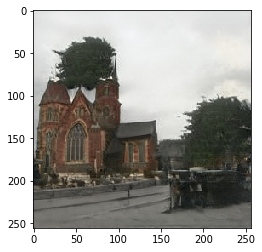

In [25]:
rendered_target = render_model(target_value)
plt.imshow(postproc(rendered_target)[0])

In [26]:
def proj(weights, basis):
    """
    Args:
        mat: torch.Tensor, [G, B, C, H, W], matrix.
        basis: torch.Tensor, [R, C], low-rank basis.
    Returns:
        torch.Tensor, [G, B, C, H, W], projected matrix.
    """
    dotprod = torch.einsum('goiyx, ri -> goryx', weights, basis)
    return torch.einsum('goryx, ri -> goiyx', dotprod, basis)

In [27]:
weights = next(param for name, param in target_model.named_parameters() if 'dconv' in name)
weights.requires_grad_()
weights.shape

torch.Size([1, 512, 512, 3, 3])

In [28]:
with torch.no_grad():
    ortho_weights = weights - proj(weights, basis)
ortho_weights.shape

torch.Size([1, 512, 512, 3, 3])

In [29]:
stylegan.load_state_dict(ckpt['g_ema'], latent_avg=ckpt['latent_avg'])

In [30]:
optim = torch.optim.Adam([weights], lr=0.05)
for i in tqdm.tqdm(range(2001)):
    optim.zero_grad()
    loss = F.l1_loss(target_value.fmap, target_model(input_key).fmap)
    loss.backward()
    # weights.grad[...] = proj(weights.grad, basis)
    optim.step()

    if i % 10 == 0:
        with torch.no_grad():
            weights[...] = ortho_weights + proj(weights, basis)

100%|██████████| 2001/2001 [00:09<00:00, 215.30it/s]


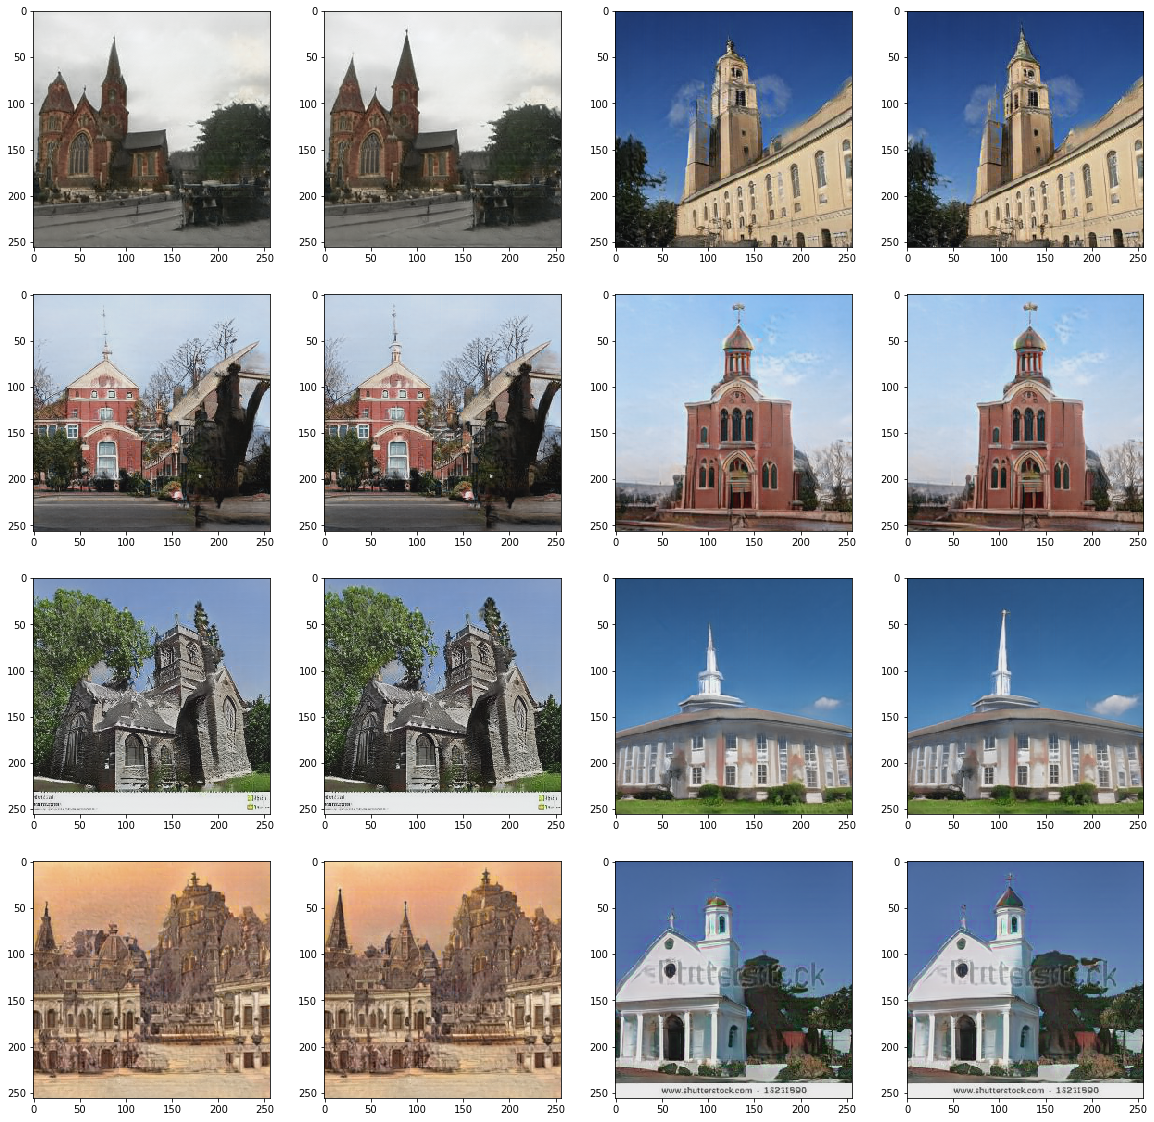

In [31]:
out = postproc(render_model(target_model(context)))

comp = np.zeros((16, 256, 256, 3))
comp[0::2] = out
comp[1::2] = sample
show(comp, row=4)